## Give Me The Next AAA Title
# Predictive Modeling
### Movie Profitability Prediction Based on Popularity
****

<br>
by Dustin Reyes
<br>
<br>
Prepared for:
<br>
Mynt (Globe Fintech Innovations, Inc.)
<br>
<br>

In [1]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
from ast import literal_eval
import matplotlib
import matplotlib.pyplot as plt
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score, make_scorer, accuracy_score
from collections import Counter
from xgboost import XGBClassifier, plot_importance
from pytrends.request import TrendReq

import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDClassifier

import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')
tqdm.pandas()
%matplotlib inline

In [2]:
df = pd.read_csv('data2/data_imdb_complete.csv')
df.drop(['originalTitle', 'primaryTitle', 'isAdult',
         'leadActor', 'tconst', 'director', 'budget_mil', 'opening_mil', 'titleType', 'top3_actors'], axis=1, inplace=True)
df.head()

,title,release,budget,opening,gross,worldwide_gross,metacritic_score,mpaa_rating,startYear,runtimeMinutes,genres,averageRating,numVotes
0,Season of the Witch,2011-01-07,40000000,10612375,24827228,91627228.0,28.0,PG-13,2011,95,Action,5.4,90902
1,The Green Hornet,2011-01-14,120000000,33526876,98780042,227817248.0,39.0,PG-13,2011,119,Action,5.8,155886
2,The Mechanic,2011-01-28,40000000,11422006,29121498,76130093.0,49.0,R,2011,93,Action,6.6,152076
3,The Rite,2011-01-28,37000000,14789393,33047633,96560591.0,38.0,PG-13,2011,114,Drama,6.0,91850
4,Sanctum,2011-02-04,30000000,9447930,23209310,108609310.0,42.0,R,2011,108,Action,5.9,53868


In [3]:
df2 = pd.read_csv('data2/movie_popularity2.csv')
df2.head()

,title,search_interest,year
0,Season of the Witch,943,2011
1,The Green Hornet,694,2011
2,The Mechanic,1260,2011
3,The Rite,1036,2011
4,Sanctum,1038,2011


In [4]:
df3 = df.merge(df2, on = 'title')
df3.head()

,title,release,budget,opening,gross,worldwide_gross,metacritic_score,mpaa_rating,startYear,runtimeMinutes,genres,averageRating,numVotes,search_interest,year
0,Season of the Witch,2011-01-07,40000000,10612375,24827228,91627228.0,28.0,PG-13,2011,95,Action,5.4,90902,943,2011
1,The Green Hornet,2011-01-14,120000000,33526876,98780042,227817248.0,39.0,PG-13,2011,119,Action,5.8,155886,694,2011
2,The Mechanic,2011-01-28,40000000,11422006,29121498,76130093.0,49.0,R,2011,93,Action,6.6,152076,1260,2011
3,The Rite,2011-01-28,37000000,14789393,33047633,96560591.0,38.0,PG-13,2011,114,Drama,6.0,91850,1036,2011
4,Sanctum,2011-02-04,30000000,9447930,23209310,108609310.0,42.0,R,2011,108,Action,5.9,53868,1038,2011


## 1. Audience Ratings vs Critic Ratings between 2011 and 2021

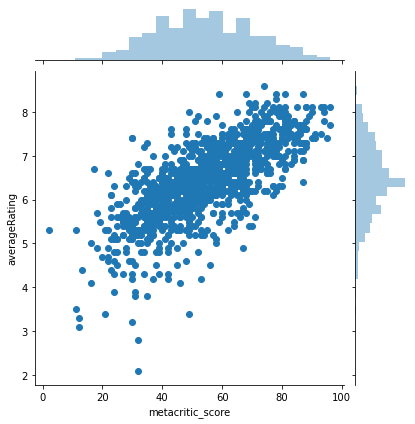

In [5]:
sns.jointplot(data=df3, x='metacritic_score', y='averageRating')

From the visualization above, we can observe that the concentration of points almost follows a straight line trend. This means that most of the audience ratings are the same with the ratings of movie critics. For audience ratings, the distribution was mostly between 6 to 8 which means that most audience ratings were particularly high while for critics, they have a wider range of scores between 35 to 70.

A finding can be made that that the general audience freely appreciates the movies by giving a score above 5. Movie critics however are more stringent and often gives lower ratings than the general audience.

## 2. Audience Ratings vs Movie Runtimes between 2011 and 2021

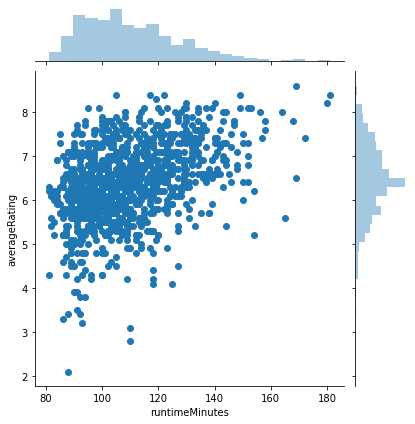

In [6]:
sns.jointplot(data=df3, y='averageRating', x='runtimeMinutes')

From the graph above, we see that most of the movies last between 60 minutes and 120 minutes with audience rating ranging from 6 to 8.

## 3. Critic Ratings vs Movie Runtimes between 2011 and 2021

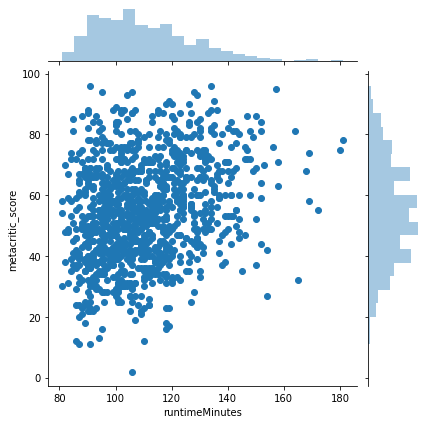

In [7]:
sns.jointplot(data=df3, y='metacritic_score', x='runtimeMinutes')

The graph above means that the most critic scores ranges between 30 to 80 with runtimes between 70 minutes to less than 140 minutes

## 4. Critic Ratings vs Movie Gross Performance between 2011 and 2021

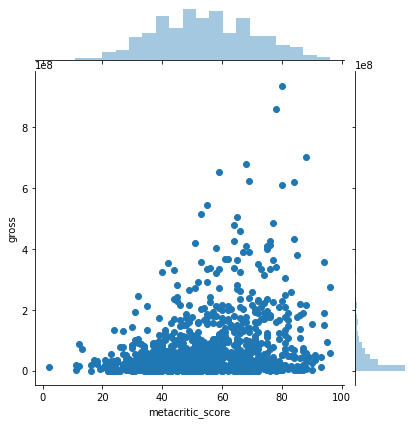

In [8]:
sns.jointplot(data=df3, x='metacritic_score', y='gross')

From the graph above, we observe that the ratings of the critics are more concentrated between 40/100 and 60/100, which means that the critics are more demanding towards the films than the public. We also note that the films that have high ratings from critics were those that performed the most in terms of gross performance.

## 5. Distribution plots of Continuous Features for Movies between 2011 and 2021

In [9]:
df3['numVotes'] = df3['numVotes'].astype(int)
df3['search_interest'] = df3['search_interest'].astype(int)

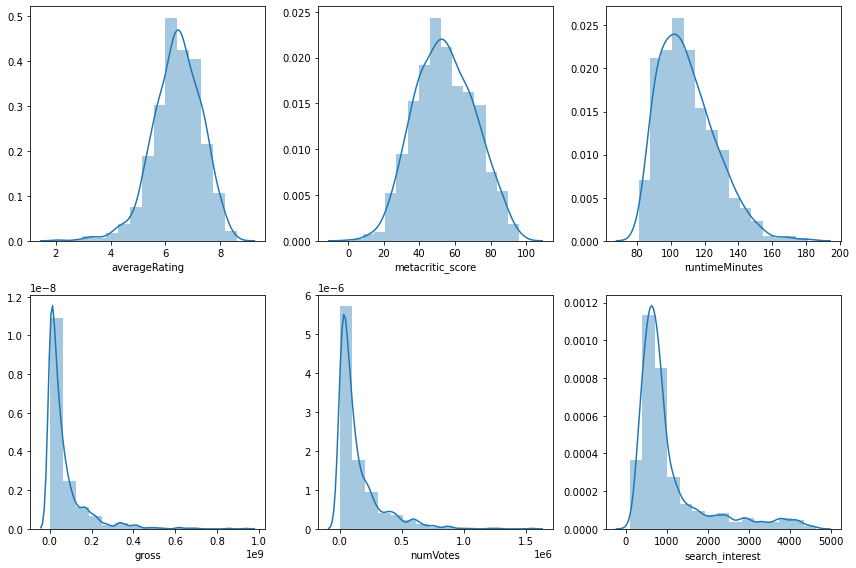

In [11]:
fig, axes = plt.subplots(2, 3)
fig.set_size_inches(12, 8)

m1 = sns.distplot(df3['averageRating'], bins=15, ax=axes[0, 0])
m2 = sns.distplot(df3['metacritic_score'], bins=15, ax=axes[0, 1])
m3 = sns.distplot(df3['runtimeMinutes'], bins=15, ax=axes[0, 2])
m4 = sns.distplot(df3['gross'], bins=15, ax=axes[1, 0])
m5 = sns.distplot(df3['numVotes'], bins=15, ax=axes[1, 1])
m6 = sns.distplot(df3['search_interest'], bins=15, ax=axes[1, 2])

#plt.setp(axes, yticks=[])
plt.tight_layout()

The following are the observations from these plots:
* Audience Average Ratings were concentrated mostly between 5 to 7 out of 10 scores.
* Critic Scores follow a normal distribution and are concentrated between 30 to 90 out of 100 scores.
* Movie Runtimes for movies released in 2011 to 2021 have most runtimes greater than 80 minutes by less than 130 minutes.
* Movie Gross Performance, Number of Audience Votes and Google Search Interests have their distribution skewed to the right.